# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, power_transform, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score,
                            roc_auc_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            make_scorer,
                            RocCurveDisplay,
                            auc,
                            roc_curve)

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# WIP onehot category preprocessor
from custom_transformers.custom_onehot_encoder import custom_one_hot

# WIP onehot category preprocessor
from custom_transformers.custom_impute_scale import custom_impute_scale


# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df

In [6]:
def processgender(df):
    _df = df.copy()
    _df['gender'] = _df['gender'].str.lower()
    valid_genders = ['male', 'female']
    _df.loc[~(_df['gender'].isin(valid_genders)), 'age'] = 'unknown'
    return _df

In [7]:
def processrace(df):
    _df = df.copy()
    _df['race'] = _df['race'].str.lower().str.lstrip().str[0:3]
    black = ['afr', 'bla']
    white = ['cau', 'whi', 'eur']
    hispanic = ['his', 'lat']
    asian = ['asi']
    race_options = black+white+hispanic+asian
    _df.loc[~(_df['race'].isin(race_options)), 'race'] = 'unknown/other'
    _df.loc[(_df['race'].isin(black)), 'race'] = 'black'
    _df.loc[(_df['race'].isin(white)), 'race'] = 'white'
    _df.loc[(_df['race'].isin(hispanic)), 'race'] = 'hispanic'
    _df.loc[(_df['race'].isin(asian)), 'race'] = 'asian'
    return _df

In [8]:
def insurancestatus(df):
    _df = testdf.copy()
    _df.payer_code = _df.payer_code.where(_df.payer_code != '?')
    _df.payer_code = _df.payer_code.fillna(value='unknown')
    _df.loc[(_df['payer_code'] == 'SP'), 'payer_code'] == 'uninsured'
    _df.loc[~(_df['payer_code'].isin(['SP', 'unknown'])), 'payer_code'] = 'insured'
    return _df

In [9]:
def processadmissiontype(df):
    _df = df.copy()
    _df.loc[(_df['admission_type_code'].isin([5, 6, 8])), 'admission_type_code'] = 'n/a'
    _df.loc[(_df['admission_type_code'] == 1), 'admission_type_code'] = 'emergency'
    _df.loc[(_df['admission_type_code'] == 2), 'admission_type_code'] = 'urgent'
    _df.loc[(_df['admission_type_code'] == 3), 'admission_type_code'] = 'elective'
    _df.loc[(_df['admission_type_code'] == 4), 'admission_type_code'] = 'newborn'
    _df.loc[(_df['admission_type_code'] == 7), 'admission_type_code'] = 'trauma'
    return _df

In [10]:
def processdischargecode(df):
    _df = df.copy()

    home = [1]
    left_ama = [7]
    hospice = [13, 14]
    transferred = [2, 3, 4, 5, 9, 10, 15, 22, 23, 24, 27, 28, 29]
    died = [11, 19, 20, 21]
    for_outpatient_services = [12, 16, 17]
    home_services = [6, 8]
    all_cats = home+left_ama+hospice+transferred+died+for_outpatient_services+home_services

    _df.loc[~(_df['discharge_disposition_code'].isin(all_cats)), 'discharge_disposition_code'] = 'unknown'
    _df.loc[(_df['discharge_disposition_code'].isin(home)), 'discharge_disposition_code'] = 'discharged_home'
    _df.loc[(_df['discharge_disposition_code'].isin(left_ama)), 'discharge_disposition_code'] = 'left_ama'
    _df.loc[(_df['discharge_disposition_code'].isin(hospice)), 'discharge_disposition_code'] = 'discharged_hospice'
    _df.loc[(_df['discharge_disposition_code'].isin(transferred)), 'discharge_disposition_code'] = 'transferred_inpatient'
    _df.loc[(_df['discharge_disposition_code'].isin(died)), 'discharge_disposition_code'] = 'expired'
    _df.loc[(_df['discharge_disposition_code'].isin(for_outpatient_services)), 'discharge_disposition_code'] = 'transferred_outpatient'
    _df.loc[(_df['discharge_disposition_code'].isin(home_services)), 'discharge_disposition_code'] = 'home_care'
    
    return _df

In [11]:
def processspecializations(df):
    _df = df.copy()
    _df['medical_specialty'] = _df['medical_specialty'].str.lower()
    counts = pd.DataFrame(_df.medical_specialty.value_counts())
    df_mask = counts['medical_specialty']>=100
    selected_specialties = counts[df_mask]
    selected_specialties = selected_specialties.index.to_list()
    _df.loc[~(_df['medical_specialty'].isin(selected_specialties)), 'medical_specialty'] = 'other'
    _df.loc[(_df['medical_specialty'] == '?'), 'medical_specialty'] = 'unknown'
    return _df

# Function to test if we satisfied requirements:

The first step will make a copy of the X_test and apply the custom converter for the columns - it will update the categories we are interested in (avoid duplicates etc)

In [12]:
def verify_no_discrimination(X_test,
                             y_true,
                             y_pred,
                             sensitive_columns = [],
                             max_diff=0.1,
                             average='weighted'):    
    # Use this as a template to get output:
    #f1_scores, diff, is_satisfied  = verify_no_discrimination(X_test,
    #                                                          y_test,
    #                                                          y_pred,
    #                                                          sensitive_column=['Self-defined ethnicity', 'race'] etc
    #                                                          max_diff=0.15 )
    #f1_scores, diff, is_satisfied
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        f1_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if mask.sum():
                f1_scores[sensitive_class] = f1_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(f1_scores.values())) - np.min(list(f1_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [f1_scores, diff, is_satisfied]
    
    return results

# Loading data

In [13]:
target = 'readmitted'
index_col = 'admission_id'

In [14]:
data_train = load_train_data()
data_train = assign_index(data_train, index_col)
data_train = build_target(data_train, target)

# Simple baseline

In [15]:
#List of all features (n=numerical, uc=unordered actegory, oc=ordered category, b=boolean)

all_features = ['patient_id', #identifier
                'race', #uc
                'gender', #uc
                'age', #oc
                'weight', #oc               
                'admission_type_code', #uc
                'discharge_disposition_code', #uc
                'admission_source_code', #uc
                'time_in_hospital', #n
                'payer_code', #uc
                'medical_specialty', #uc
                'has_prosthesis', #b
                'complete_vaccination_status', #uc
                'num_lab_procedures', #n
                'num_procedures', #n
                'num_medications', #n
                'number_outpatient', #n
                'number_emergency', #n
                'number_inpatient', #n
                'diag_1', #uc
                'diag_2', #uc
                'diag_3', #uc
                'number_diagnoses', #n
                'blood_type', #uc
                'hemoglobin_level', #n
                'blood_transfusion', #b
                'max_glu_serum', #oc
                'A1Cresult', #oc
                'diuretics', #b
                'insulin', #b
                'change', #b
                'diabetesMed'] #b]

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type']

ord_cat_features = ['age',
                    'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

# missing features: date of admission and date of release

### Test train split

In [16]:
# Convert target to boolean

# We have a small portion kept aside because of our random undersampling approach where we lose a lot of train data 
df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=data_train[target])

In [17]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [18]:
selected_features = ['time_in_hospital', 
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'hemoglobin_level',
                     
                     'has_prosthesis',
                     'blood_transfusion',
                     'diuretics',
                     'insulin',
                     'change',
                     'diabetesMed',
                     
                     'race',
                     'gender',
                     'admission_type_code', 
                     'discharge_disposition_code',
                     'admission_source_code', 
                     'payer_code',
                     'medical_specialty',
                     'complete_vaccination_status',
                     'blood_type',
                     
                     'max_glu_serum',
                     'A1Cresult',
                     'age',
                     'weight']

In [19]:
num_feats = [feat for feat in selected_features if feat in num_features]
cat_feats = [feat for feat in selected_features if feat in cat_features+bool_features+ord_cat_features]
bool_feats = [feat for feat in selected_features if feat in bool_features]
ord_cat_feats = [feat for feat in selected_features if feat in ord_cat_features]

# Pipeline 1 - just numerical features

#### Numbers processed in a custom transformer (part of the ColumnConverter) - will be placed into a separate file
1. Missing values imputed using KNNImputer
2. Values have a significant skew, so RobustScaler was selected to avoid outliers having hige impact

In [20]:
num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

In [21]:
pipeline = make_pipeline(
    ColumnConverter(),
    SelectColumns(cols=num_feats),
    SimpleImputer(strategy="median"),
    RandomForestClassifier(max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# To use on other cells
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
#verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

f1 score: 0.24249922672440452
recall score: 0.432194046306505
precision score: 0.16852966466036112
discrimination results:


# Pipeline 2 - adding the binary features

In [22]:
bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

In [23]:
pipeline = make_pipeline(
    ColumnConverter(),
    SelectColumns(cols=num_feats+bool_feats),
    SimpleImputer(strategy="median"),
    RandomForestClassifier(max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# To use on other cells
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

f1 score: 0.24733096085409254
recall score: 0.4597574421168688
precision score: 0.16916835699797161
discrimination results:


/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'unknown': 0.2524383247274814,
   'surgery-general': 0.2626262626262626,
   'emergency/trauma': 0.281786941580756,
   'internalmedicine': 0.22641509433962262,
   'cardiology': 0.19402985074626866,
   'family/generalpractice': 0.22857142857142856,
   'orthopedics-reconstructive': 0.28571428571428575,
   'hematology/oncology': 0.25,
   'radiologist': 0.0,
   'gastroenterology': 0.28571428571428575,
   'other': 0.21621621621621623,
   'pulmonology': 0.24242424242424246,
   'surgery-neuro': 0.3333333333333333,
   'surgery-vascular': 0.23529411764705882,
   'psychiatry': 0.2608695652173913,
   'surgery-cardiovascular/thoracic': 0.13333333333333333,
   'neurology': 0.0,
   'urology': 0.2222222222222222,
   'oncology': 0.25000000000000006,
   'physicalmedicineandrehabilitation': 0.30769230769230765,
   'orthopedics': 0.22222222222222224,
   'pediatrics': 0.0,
   'obstetricsandgynecology': 0.42857142857142855,
   'nephrology': 0.37037037037037035,
   'pediatrics-endocri

# Pipeline 3 - adding ordered categorical variables

1. added age, weight, max_glu_serum, A1Cresult, and also encoded vaccination status here
2. also did some playing around with the model options for fun

In [24]:
ord_cat_features = ['age',
                    #'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

In [25]:
pipeline = make_pipeline(
    ColumnConverter(),
    custom_oe(),
    SelectColumns(cols=num_feats+bool_feats+ord_cat_feats),
    SimpleImputer(strategy="median"),
    RandomForestClassifier(max_depth=10,
                           class_weight="balanced",
                           random_state=42,
                           n_jobs=-1,
                           criterion = 'entropy',
                           bootstrap = False))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# To use on other cells
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
#verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

f1 score: 0.2523591264491777
recall score: 0.515986769570011
precision score: 0.1670235546038544
discrimination results:


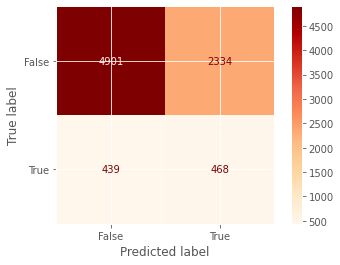

In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

Trying gradient boosting classifier

In [27]:
pipeline = make_pipeline(
    ColumnConverter(),
    custom_oe(),
    SelectColumns(cols=num_feats+bool_feats+ord_cat_feats),
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(learning_rate=.1,
                               n_estimators=20,
                               subsample=0.2,
                               n_iter_no_change=10,
                               max_features = None,
                               random_state=42)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# To use on other cells
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
#verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

f1 score: 0.010893246187363833
recall score: 0.005512679162072767
precision score: 0.45454545454545453
discrimination results:


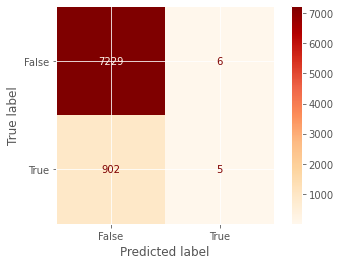

In [28]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

Trying a grid search

In [29]:
f1_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score)

pipeline = make_pipeline(
    ColumnConverter(),
    custom_oe(),
    SelectColumns(cols=num_feats+bool_feats+ord_cat_feats),
    SimpleImputer(strategy="median"),
    GridSearchCV(DecisionTreeClassifier(random_state=42),
                                      param_grid = {'max_depth': range(1, 10),
                                                    'max_features': ['auto', 'sqrt', 'log2', None],
                                                    #'max_features': range(1, X.shape[1]),
                                                    'criterion': ['entropy', 'gini']},
                                      cv=10,
                                      scoring=roc_auc_scorer, #or should it be 'accuracy'
                                      return_train_score=True))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# To use on other cells
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
#verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

KeyboardInterrupt: 

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Adding categorical variables

In [ ]:
cat_features = ['race', #done
                'gender', #done
                'admission_type_code', #done 
                'discharge_disposition_code', #done
                'admission_source_code', #done 
                'payer_code', #done (now the insurance column)
                'medical_specialty', #done (any specialty over 100 - lets see how bad it gets)
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type'
               ] #dropping blood type

1. Will drop blood type - too many inconsistencies and not feasible to guess
1. Does admission type and code have a role?
1. Race, gender can be encoded
1. Payer code 'SP' is an indicator of uninsured patients - what to do with '?' should we make 3 categories?

### Processing Diagnoses:
1. High cardinality (and possibly redundant information due to overlap with the speecialty?)
1. Used encoding system to try to group (by large groups of diagnoses - definetely losing a lot of resolution here):
    1. Diagnostic_categories = ['infection', #001-139
                         'neoplasms', #140-239
                         'endocrine_nutritional_metabolic_immune', #240-279
                         'blood', #280-289
                         'mental', #290-319
                         'nervous_system', #320-389
                         'circulatory', #390-459
                         'respiratory', #460-519
                         'digestive', #520-579
                         'genitourinary', #580-629
                         'pregnancy', #630-679
                         'skin', #680-709
                         'musculoskeletal', #710-739
                         'congenital', #740-759
                         'perinatal', #760-779
                         'ill_defined', #780-799
                         'injury_poisoning', #800-899, also E800-E999
                         'supplemental' #V01-V89
                        ]
1. Next step may be to use encoding from RTF files and try tfidf vectorizer

In [ ]:
X_train.dtypes

In [ ]:
_df = X_train.copy()
cc = ColumnConverter()
_df = cc.fit_transform(_df)
coe = custom_oe()
_df = coe.fit_transform(_df)

In [ ]:
onehot = custom_one_hot()
_df = onehot.fit_transform(_df)

In [ ]:
raise notimplementederror

In [ ]:
_df.dtypes

In [ ]:
cats = _df.select_dtypes(include = 'category').columns.tolist()

In [ ]:
cats

In [ ]:
_df['change'] = _df['change'].astype('bool')

In [ ]:
_df.change.isnull().sum()

In [ ]:
_df = _df.copy()[cat_features]
_df.dtypes

In [ ]:
_df.head()

In [ ]:
oh = OneHotEncoder(cols = ['race', 'gender'], handle_unknown='indicator', handle_missing='indicator', use_cat_names = True)
_df = oh.fit_transform(_df)

# A quick test

In [ ]:
## put this into a custom transformer please

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        #('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_features)])

In [ ]:
pipeline = make_pipeline(
    ColumnConverter(),
    SelectColumns(cols=num_feats+bool_feats+ord_cat_feats+cat_features),
    custom_oe(),
    preprocessor,
    RandomForestClassifier(max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

In [ ]:
pipeline = make_pipeline(
    ColumnConverter(),
    SelectColumns(cols=num_feats+bool_feats+ord_cat_feats+cat_features),
    custom_oe(),
    preprocessor,
    GradientBoostingClassifier(learning_rate=.1,
                               n_estimators=100,
                               subsample=0.2,
                               n_iter_no_change=10,
                               max_features = None,
                               random_state=42)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race'])

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Output files (pickling)

In [ ]:
TMP_DIR = '/tmp'
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 